Import libraries

In [1]:
import pandas as pd
from pmdarima import auto_arima
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.statespace.sarimax import SARIMAX
import sys
from pathlib import Path

# Get the parent directory
parent_dir = Path.cwd().parent.parent

# Ensure it's not already in sys.path
if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))
from shared.metrics import print_evaluation_metrics
from shared.helpers import store_model

Load dataset and prepare df

In [2]:
file_path = "../data/parsed_dataset.csv"
date_column = "Date_reported"
target_column = "New_deaths"
df = pd.read_csv(file_path, parse_dates=True)
df = df[[date_column, target_column]]

df = df.groupby(date_column).sum().reset_index()
df.set_index(date_column, inplace=True)
df = df.dropna()
dates = df.index.values

Train test split

In [3]:
data_length = len(df)
train_split = 0.9
train = df.iloc[:int(data_length*train_split)]
test = df.iloc[int(data_length*train_split):]

Parameter tuning for order and seasonal order

In [4]:
stepwise_fit = auto_arima(
    df[target_column],
    trace=True,
    suppress_warnings=True,
    max_P=3,
    max_D=2,
    max_Q=3,
    m=12,
    stepwise=True,
)
best_order = stepwise_fit.order
best_seasonal_order = stepwise_fit.seasonal_order

Performing stepwise search to minimize aic


 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=25380.343, Time=18.06 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=26399.060, Time=0.08 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=25895.379, Time=2.18 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=25501.119, Time=6.54 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=26397.060, Time=0.08 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=25390.044, Time=15.88 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=inf, Time=16.58 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=26790.651, Time=102.44 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=26086.365, Time=36.97 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=25434.630, Time=5.99 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=25248.180, Time=29.39 sec
 ARIMA(2,1,2)(0,0,3)[12] intercept   : AIC=inf, Time=124.84 sec
 ARIMA(2,1,2)(1,0,3)[12] intercept   : AIC=inf, Time=52.98 sec
 ARIMA(1,1,2)(0,0,2)[12] intercept   : AIC=25327.265, Time=21.81 sec
 ARIMA(2,1,1)(0,0,2)[12] intercept   : AIC=25367.373, T

In [5]:
print(best_order)
print(best_seasonal_order)

(2, 1, 3)
(0, 0, 2, 12)


Create Model

In [6]:
model = SARIMAX(
    train[target_column], order=best_order, seasonal_order=best_seasonal_order
)
model = model.fit()
model.summary()

/home/samuell/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/samuell/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.28458D+00    |proj g|=  2.21039D-01


 This problem is unconstrained.



At iterate    5    f=  9.19416D+00    |proj g|=  1.08582D-01

At iterate   10    f=  9.13964D+00    |proj g|=  4.07728D-02

At iterate   15    f=  9.12121D+00    |proj g|=  2.12438D-02

At iterate   20    f=  9.12039D+00    |proj g|=  1.37735D-03

At iterate   25    f=  9.12038D+00    |proj g|=  1.67406D-04

At iterate   30    f=  9.12033D+00    |proj g|=  4.27978D-03

At iterate   35    f=  9.10055D+00    |proj g|=  7.18388D-02

At iterate   40    f=  9.05357D+00    |proj g|=  4.15750D-02

At iterate   45    f=  9.03431D+00    |proj g|=  1.15108D-01

At iterate   50    f=  8.99290D+00    |proj g|=  2.84101D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/home/samuell/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                              New_deaths   No. Observations:                 1251
Model:             SARIMAX(2, 1, 3)x(0, 0, [1, 2], 12)   Log Likelihood              -11250.113
Date:                                 Tue, 30 Apr 2024   AIC                          22516.226
Time:                                         18:07:58   BIC                          22557.273
Sample:                                     02-02-2020   HQIC                         22531.657
                                          - 07-06-2023                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.8030      0.003   -708.796      0.000      -1.808      -1.798
ar.L2         -0.9991      0.002   -482.051      0.000      -1.003      -0.995
ma.L1          1.0365      0.019     54.209      0.000       0.999       1.074
ma.L2         -0.4361      0.030    -14.661      0.000      -0.494      -0.378
ma.L3         -0.6925      0.017    -41.692      0.000      -0.725      -0.660
ma.S.L12      -0.6477      0.018    -36.137      0.000      -0.683      -0.613
ma.S.L24       0.1353      0.024      5.630      0.000       0.088       0.182
sigma2       3.83e+06   7.52e-10   5.09e+15      0.000    3.83e+06    3.83e+06
===================================================================================
Ljung-Box (L1) (Q):                  29.98   Jarque-Bera (JB):              2179.03
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.33   Skew:                             0.82
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.98e+31. Standard errors may be unstable.
"""

In [7]:
start = len(train)
end = len(train) + len(test) - 1
pred = model.predict(start=start, end=end, typ="levels")

/home/samuell/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [8]:
non_zero = []
 
for i in pred:
    removed_initial_one = i-1
    if removed_initial_one == 0:
        non_zero.append(removed_initial_one+sys.float_info.min)
    else:
        non_zero.append(removed_initial_one)

Plot the result

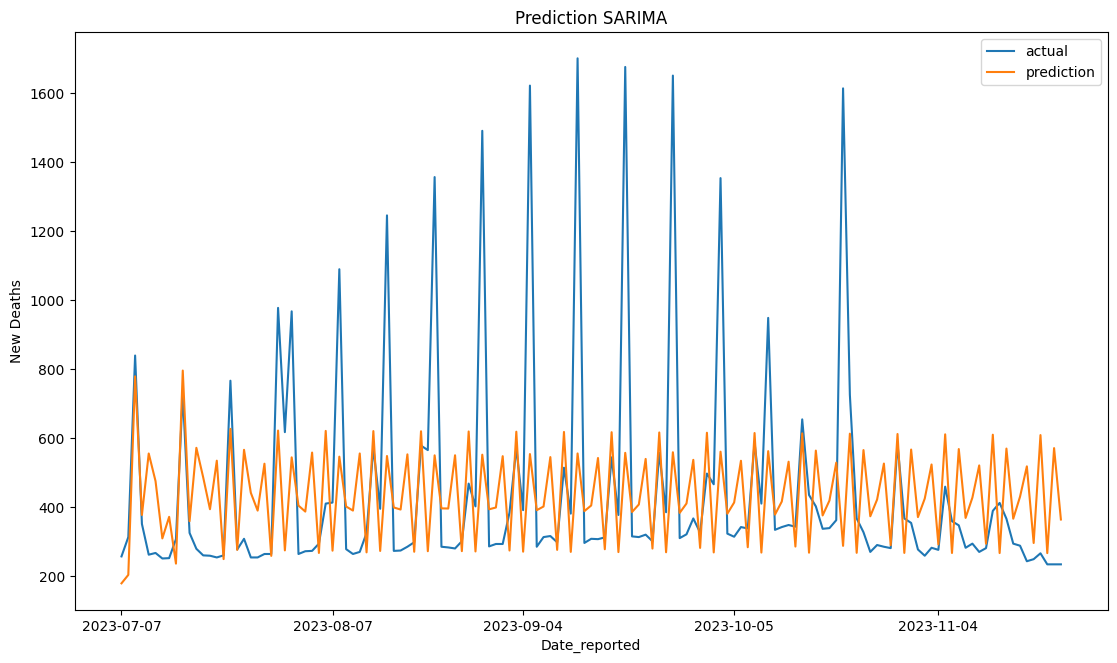

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(1280 / 96, 720 / 96))
ax.plot(dates[int(data_length*train_split):], (test[target_column]-1).values, label="actual")
ax.plot(dates[int(data_length*train_split):], list(pred), label="prediction")
ax.set_title("Prediction SARIMA")
ax.set_ylabel("New Deaths")
ax.set_xlabel(date_column)
ax.legend()
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.show()

RMSE of the result

In [10]:
print_evaluation_metrics(non_zero, test[target_column]-1, train[target_column]-1)

Evaluation Metrics:
MSE: 93945.51
RMSE: 306.51
MAE: 194.20
MAPE: 42.08
SMAPE: 38.12
MASE: 0.11


In [11]:
store_model(model, "sarima")